Sept 9, 2023: finetuning my own adapter using llama_index code

In [1]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from src.logger import logger

## 1. Load base embedding model; use Helper fns for adapter model, loss, optimizer
- For the adapter, we use a linear model created using the nn.Module class.  There are 3 functions (get_config_dict, save and load) that is less typically, but allows one to save the adapter for later use.
- The loss function also uses the nn.Module class, which allows a simpler application of the adapter.  However, this could be done in alternative methods.

In [2]:
from llama_index.embeddings import resolve_embed_model
from src.adapter import LinearModel, LossFunction, optimizer
embed_model = resolve_embed_model("local:BAAI/bge-small-en")
adapter = LinearModel(embed_model=embed_model)
device='cpu'
#device='mps'
loss_function = LossFunction(model=adapter, device=device)
opt = optimizer(model=adapter, lr=1e-3)

## 2. Create a Dataset and a DataLoader
This is done in the fairly standard way.  The only step to note is that the collate function converts the text into embeddings using the embedding model, so the partial function is needed.

In [3]:
from llama_index.finetuning import EmbeddingQAFinetuneDataset
from torch.utils.data import DataLoader
from src.adapter import data_to_dataset, collate_fn
from functools import partial

In [4]:
data = EmbeddingQAFinetuneDataset.from_json("../data/train_dataset.json")
data_validate = EmbeddingQAFinetuneDataset.from_json("../data/val_dataset.json")
dataset = data_to_dataset(data)
dataset_validate = data_to_dataset(data_validate)
collate_fn_ = partial(collate_fn, embed_model=embed_model)
data_loader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn_, shuffle=True)
data_loader_validate = DataLoader(dataset_validate, batch_size=32, collate_fn=collate_fn_, shuffle=False)

2023-09-17 12:00:32,315 - src.logger - INFO - **MSP: Number of examples: 198
2023-09-17 12:00:32,316 - src.logger - INFO - **MSP: Number of examples: 204


## 3. Set up parameters for Training

In [5]:
adapter.to(device)
loss_function.to(device)
epochs = 8
steps_per_epoch = len(data_loader)
num_train_steps = int(epochs * steps_per_epoch)
logger.info(f'Number of steps per epoch: {steps_per_epoch}')
logger.info(f'Number of training steps: {num_train_steps}')

2023-09-17 12:00:32,378 - src.logger - INFO - Number of steps per epoch: 7
2023-09-17 12:00:32,379 - src.logger - INFO - Number of training steps: 56


## 4. Training Loop

In [6]:
from tqdm.autonotebook import trange
from llama_index.bridge.langchain import print_text

global_step = 0
lst_train_loss = []
lst_val_loss = []
lst_train_acc = []
lst_val_acc = []
lst_train_top2 = []
lst_val_top2 = []

for epoch in trange(epochs, desc="Epoch"):

    loss_function.zero_grad()
    loss_function.train()
    data_iterator = iter(data_loader)
    for query, context in data_iterator:


        loss_value = loss_function(query, context)
        loss_value.backward()
        print_text(f"> [Epoch {epoch}] Current loss: {loss_value}\n", color="blue")
        
        opt.step()
        opt.zero_grad()

    loss_function.eval()

    train_loss = sum([loss_function(q,e) for q,e in data_loader])
    val_loss = sum([loss_function(q,e) for q,e in data_loader_validate])
    train_acc = loss_function.accuracy(data_loader)
    val_acc = loss_function.accuracy(data_loader_validate)
    train_top2 = loss_function.topk(data_loader)
    val_top2 = loss_function.topk(data_loader_validate)

    lst_train_loss.append(train_loss.item())
    lst_val_loss.append(val_loss.item())
    lst_train_acc.append(train_acc)
    lst_val_acc.append(val_acc)
    lst_train_top2.append(train_top2)
    lst_val_top2.append(val_top2)

    logger.info(f"Epoch {epoch} train loss: {train_loss:.4f}")
    logger.info(f"Epoch {epoch} val loss: {val_loss:.4f}")
    logger.info(f"Epoch {epoch} train acc: {train_acc:.4f}")
    logger.info(f"Epoch {epoch} val acc: {val_acc:.4f}")
    logger.info(f"Epoch {epoch} train top2: {train_top2:.4f}")
    logger.info(f"Epoch {epoch} val top2: {val_top2:.4f}")

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

> [Epoch 0] Current loss: 2.225245475769043
> [Epoch 0] Current loss: 2.0849952697753906
> [Epoch 0] Current loss: 1.936782956123352
> [Epoch 0] Current loss: 2.226872444152832
> [Epoch 0] Current loss: 1.6999047994613647
> [Epoch 0] Current loss: 1.7819148302078247
> [Epoch 0] Current loss: 0.21449601650238037


2023-09-17 12:03:16,588 - src.logger - INFO - **MSP: Num topk: 179, total: 198
2023-09-17 12:03:45,297 - src.logger - INFO - **MSP: Num topk: 155, total: 204
2023-09-17 12:03:45,297 - src.logger - INFO - Epoch 0 train loss: 10.1374
2023-09-17 12:03:45,298 - src.logger - INFO - Epoch 0 val loss: 14.1295
2023-09-17 12:03:45,298 - src.logger - INFO - Epoch 0 train acc: 0.7576
2023-09-17 12:03:45,298 - src.logger - INFO - Epoch 0 val acc: 0.4216
2023-09-17 12:03:45,298 - src.logger - INFO - Epoch 0 train top2: 0.9040
2023-09-17 12:03:45,298 - src.logger - INFO - Epoch 0 val top2: 0.7598


> [Epoch 1] Current loss: 1.4815399646759033
> [Epoch 1] Current loss: 1.5802593231201172
> [Epoch 1] Current loss: 1.6123963594436646
> [Epoch 1] Current loss: 1.5112159252166748
> [Epoch 1] Current loss: 1.5986318588256836
> [Epoch 1] Current loss: 1.2364214658737183
> [Epoch 1] Current loss: 0.30965933203697205


2023-09-17 12:06:27,201 - src.logger - INFO - **MSP: Num topk: 187, total: 198
2023-09-17 12:06:55,499 - src.logger - INFO - **MSP: Num topk: 154, total: 204
2023-09-17 12:06:55,500 - src.logger - INFO - Epoch 1 train loss: 7.5985
2023-09-17 12:06:55,500 - src.logger - INFO - Epoch 1 val loss: 13.3333
2023-09-17 12:06:55,500 - src.logger - INFO - Epoch 1 train acc: 0.7828
2023-09-17 12:06:55,501 - src.logger - INFO - Epoch 1 val acc: 0.4314
2023-09-17 12:06:55,501 - src.logger - INFO - Epoch 1 train top2: 0.9444
2023-09-17 12:06:55,501 - src.logger - INFO - Epoch 1 val top2: 0.7549


> [Epoch 2] Current loss: 1.452121376991272
> [Epoch 2] Current loss: 1.2540125846862793
> [Epoch 2] Current loss: 1.3020905256271362
> [Epoch 2] Current loss: 1.2142542600631714
> [Epoch 2] Current loss: 1.1839805841445923
> [Epoch 2] Current loss: 0.9008428454399109
> [Epoch 2] Current loss: 0.3479844033718109


2023-09-17 12:09:43,340 - src.logger - INFO - **MSP: Num topk: 190, total: 198
2023-09-17 12:10:11,459 - src.logger - INFO - **MSP: Num topk: 159, total: 204
2023-09-17 12:10:11,460 - src.logger - INFO - Epoch 2 train loss: 6.3902
2023-09-17 12:10:11,460 - src.logger - INFO - Epoch 2 val loss: 12.7648
2023-09-17 12:10:11,461 - src.logger - INFO - Epoch 2 train acc: 0.8283
2023-09-17 12:10:11,461 - src.logger - INFO - Epoch 2 val acc: 0.4363
2023-09-17 12:10:11,461 - src.logger - INFO - Epoch 2 train top2: 0.9596
2023-09-17 12:10:11,461 - src.logger - INFO - Epoch 2 val top2: 0.7794


> [Epoch 3] Current loss: 0.9148919582366943
> [Epoch 3] Current loss: 0.9687853455543518
> [Epoch 3] Current loss: 1.0518913269042969
> [Epoch 3] Current loss: 0.9524091482162476
> [Epoch 3] Current loss: 1.2116895914077759
> [Epoch 3] Current loss: 0.9719576835632324
> [Epoch 3] Current loss: 0.18263258039951324


2023-09-17 12:18:03,040 - src.logger - INFO - **MSP: Num topk: 193, total: 198
2023-09-17 12:18:29,974 - src.logger - INFO - **MSP: Num topk: 158, total: 204
2023-09-17 12:18:29,974 - src.logger - INFO - Epoch 3 train loss: 5.4062
2023-09-17 12:18:29,975 - src.logger - INFO - Epoch 3 val loss: 12.4385
2023-09-17 12:18:29,975 - src.logger - INFO - Epoch 3 train acc: 0.8889
2023-09-17 12:18:29,975 - src.logger - INFO - Epoch 3 val acc: 0.4265
2023-09-17 12:18:29,975 - src.logger - INFO - Epoch 3 train top2: 0.9747
2023-09-17 12:18:29,976 - src.logger - INFO - Epoch 3 val top2: 0.7745


> [Epoch 4] Current loss: 0.9235138893127441
> [Epoch 4] Current loss: 0.8729078769683838
> [Epoch 4] Current loss: 0.7304924726486206
> [Epoch 4] Current loss: 0.875950813293457
> [Epoch 4] Current loss: 0.7505472302436829
> [Epoch 4] Current loss: 0.9679754972457886
> [Epoch 4] Current loss: 0.23079527914524078


2023-09-17 12:36:49,038 - src.logger - INFO - **MSP: Num topk: 193, total: 198
2023-09-17 12:38:04,601 - src.logger - INFO - **MSP: Num topk: 154, total: 204
2023-09-17 12:38:04,601 - src.logger - INFO - Epoch 4 train loss: 5.1190
2023-09-17 12:38:04,602 - src.logger - INFO - Epoch 4 val loss: 12.1957
2023-09-17 12:38:04,602 - src.logger - INFO - Epoch 4 train acc: 0.8485
2023-09-17 12:38:04,602 - src.logger - INFO - Epoch 4 val acc: 0.4216
2023-09-17 12:38:04,602 - src.logger - INFO - Epoch 4 train top2: 0.9747
2023-09-17 12:38:04,603 - src.logger - INFO - Epoch 4 val top2: 0.7549


> [Epoch 5] Current loss: 0.7947784662246704
> [Epoch 5] Current loss: 0.6052149534225464
> [Epoch 5] Current loss: 0.9055888056755066
> [Epoch 5] Current loss: 0.8183773159980774
> [Epoch 5] Current loss: 0.7694773077964783
> [Epoch 5] Current loss: 0.6609117388725281
> [Epoch 5] Current loss: 0.17004455626010895


2023-09-17 12:43:21,915 - src.logger - INFO - **MSP: Num topk: 197, total: 198
2023-09-17 12:43:48,526 - src.logger - INFO - **MSP: Num topk: 158, total: 204
2023-09-17 12:43:48,526 - src.logger - INFO - Epoch 5 train loss: 4.7988
2023-09-17 12:43:48,526 - src.logger - INFO - Epoch 5 val loss: 12.0035
2023-09-17 12:43:48,526 - src.logger - INFO - Epoch 5 train acc: 0.9040
2023-09-17 12:43:48,527 - src.logger - INFO - Epoch 5 val acc: 0.4265
2023-09-17 12:43:48,527 - src.logger - INFO - Epoch 5 train top2: 0.9949
2023-09-17 12:43:48,527 - src.logger - INFO - Epoch 5 val top2: 0.7745


> [Epoch 6] Current loss: 0.623045802116394
> [Epoch 6] Current loss: 0.7132888436317444
> [Epoch 6] Current loss: 0.6590090990066528
> [Epoch 6] Current loss: 0.750653088092804
> [Epoch 6] Current loss: 0.6539050340652466
> [Epoch 6] Current loss: 0.6757723689079285
> [Epoch 6] Current loss: 0.1368456333875656


2023-09-17 12:46:28,678 - src.logger - INFO - **MSP: Num topk: 198, total: 198
2023-09-17 12:46:58,500 - src.logger - INFO - **MSP: Num topk: 156, total: 204
2023-09-17 12:46:58,500 - src.logger - INFO - Epoch 6 train loss: 3.9404
2023-09-17 12:46:58,500 - src.logger - INFO - Epoch 6 val loss: 11.9608
2023-09-17 12:46:58,501 - src.logger - INFO - Epoch 6 train acc: 0.8939
2023-09-17 12:46:58,501 - src.logger - INFO - Epoch 6 val acc: 0.4167
2023-09-17 12:46:58,501 - src.logger - INFO - Epoch 6 train top2: 1.0000
2023-09-17 12:46:58,501 - src.logger - INFO - Epoch 6 val top2: 0.7647


> [Epoch 7] Current loss: 0.609352707862854
> [Epoch 7] Current loss: 0.5639241337776184
> [Epoch 7] Current loss: 0.5620526075363159
> [Epoch 7] Current loss: 0.6034680604934692
> [Epoch 7] Current loss: 0.7236881256103516
> [Epoch 7] Current loss: 0.6618571877479553
> [Epoch 7] Current loss: 0.10093598812818527


2023-09-17 12:49:42,152 - src.logger - INFO - **MSP: Num topk: 197, total: 198
2023-09-17 12:50:09,741 - src.logger - INFO - **MSP: Num topk: 156, total: 204
2023-09-17 12:50:09,741 - src.logger - INFO - Epoch 7 train loss: 3.3600
2023-09-17 12:50:09,742 - src.logger - INFO - Epoch 7 val loss: 11.8968
2023-09-17 12:50:09,742 - src.logger - INFO - Epoch 7 train acc: 0.8990
2023-09-17 12:50:09,742 - src.logger - INFO - Epoch 7 val acc: 0.4167
2023-09-17 12:50:09,742 - src.logger - INFO - Epoch 7 train top2: 0.9949
2023-09-17 12:50:09,743 - src.logger - INFO - Epoch 7 val top2: 0.7647


## 5. Performance

In [21]:
import matplotlib.pyplot as plt
x = list(range(1, epochs+1))

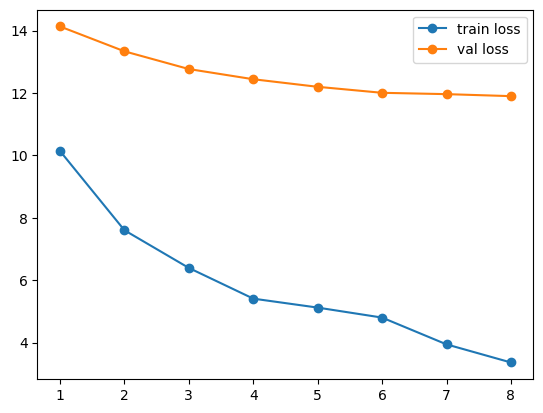

In [22]:
plt.plot(x, lst_train_loss, 'o-', label='train loss')
plt.plot(x, lst_val_loss, 'o-',label='val loss')
plt.legend()
plt.show()

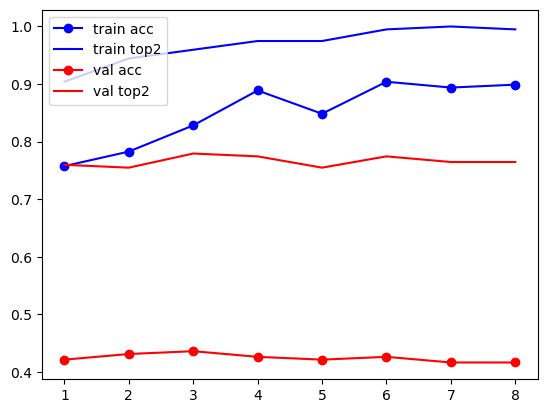

In [23]:
plt.plot(x, lst_train_acc, 'o-', color='blue', label='train acc')
plt.plot(x, lst_train_top2, '-', color='blue', label='train top2')
plt.plot(x, lst_val_acc,  'o-', color='red', label='val acc')
plt.plot(x, lst_val_top2,  '-', color='red', label='val top2')
plt.legend()
plt.show()